In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
import numpy as np
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def get_loss_history(optimizer, epochs=2):
    
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))

    mnist = tf.keras.datasets.mnist

    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    q = LossHistory()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=2, verbose=False, callbacks=[q])
    
    def moving_average(a, n=5) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    
    return moving_average(q.losses)

In [3]:
from ggt_modifications import GGTOptimizer as CustomGGT

In [4]:
logs_use_expectations = [get_loss_history(CustomGGT(use_expectations=True)) for _ in range(3)]
logs_original_method = [get_loss_history(CustomGGT(use_expectations=False)) for _ in range(3)]
logs_use_random_noise = [get_loss_history(CustomGGT(use_expectations=False, std=0.0001)) for _ in range(3)]

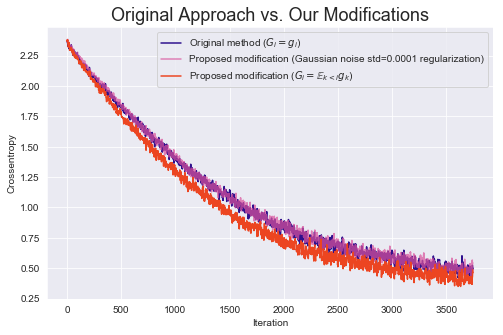

In [5]:
sns.set_style(style='darkgrid')

plt.figure(figsize=[8, 5])
plt.plot(np.mean(logs_original_method, axis=0), label=r'Original method ($G_i = g_i$)', color='#2e108d' )
plt.plot(np.mean(logs_use_random_noise, axis=0), label=r'Proposed modification (Gaussian noise std=0.0001 regularization)' , color='#da529c', alpha=0.7)
plt.plot(np.mean(logs_use_expectations, axis=0), label=r'Proposed modification ($G_i = \mathbb{E}_{k<i} g_k$)', color='#ec4521')
plt.ylabel('Crossentropy')
plt.xlabel('Iteration')
plt.title('Original Approach vs. Our Modifications', fontdict={'fontsize': 18})
plt.legend()